# Diffusion bridge on a Toy Model

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from aim.pytorch_lightning import AimLogger
import matplotlib.pyplot as plt

from mixturevqvae.datasets import toy_dataset
from mixturevqvae.prior.bridge.toy.toy_diffusion import Net
from mixturevqvae.prior.toy_diffusion import ToyModel, LitToyModel

%load_ext autoreload
%autoreload 2

## Toy generated dataset

we propose the following toy dataset: 

- size $N = 1000$, 
- vocabulary size $K = 8$, 
- length of each sequence $s = 5$, 
- vector representation size $d = 2$,
- a simple dependency between  dimensions of $X$: $X^0$ uniform, and $X^{i+1} = X^i ± 1 mod K$

Generated sequence: [4 5 4 5 6]


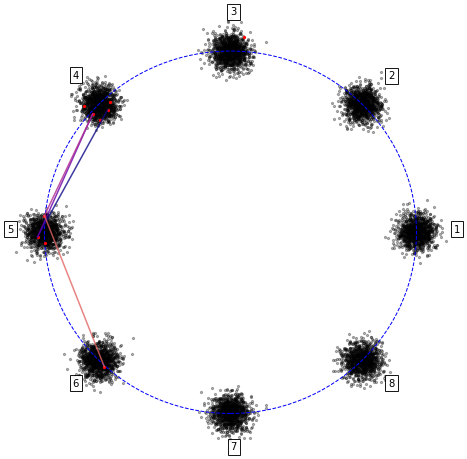

In [2]:
K = 8
s = 5
d = 2

td = toy_dataset.ToyDataset(N=10000, K=K, d=s)
td.display_data()
print(f"Generated sequence: {td.discretize(td.np_data[2])+1}")

## Simple diffusion bridge

We define a DiffusionBridge module.
3 Submodules are implicitely defined:
- A TimeEmbedding, taken from Ho diffusion, which projects discrete times into continuous vectors
- A small Net module, which has several layers and performs the denoising
- A diffusion bridge class, which encapsulate the fw, bw diffusion, training loop, and sampling procedure

In [3]:
num_steps = 100

delta_schedule = torch.full((num_steps,), 1 / num_steps)*1.5
litmodule = LitToyModel(denoising_model=Net(dim=d, hidden_dim=32), delta_schedule=delta_schedule, num_steps=num_steps, K=K, dim=d)
toy_model = litmodule.toy_model

KL=0.009629252509160607


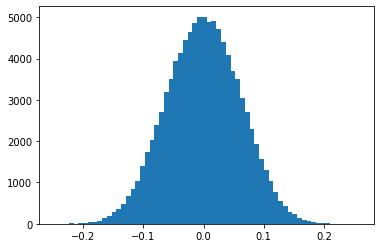

In [4]:
x_T = toy_model.posterior_sample(x=td.data_torch, t=torch.full((td.data_torch.shape[0],), num_steps))

mu_1 = x_T.mean().item()
std_0 = np.sqrt(toy_model.eta2 / (2 * toy_model.theta))
std_1 = x_T.std().item()
kl = 0.5 * (std_0 / std_1 -1 + np.square(mu_1 / std_1) - np.log(std_0/std_1))
print(f"KL={kl}")
plt.hist(x_T.flatten().numpy(), bins=64);

### Step by step noising

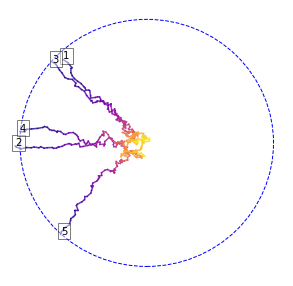

In [5]:
trajs_diff = [td.data_torch[2:3]]
for t in range(1, num_steps+1):
    trajs_diff.append(
        toy_model.posterior_onestep_sample(x=trajs_diff[-1], t=torch.full((1,), t))
    )
trajs_diff = torch.cat(trajs_diff, dim=0)

td.display_traj(trajs_diff.numpy(), annotate="start")
# plt.scatter(*torch.cat([batch for batch in toy_model.prior_initial_sample((100, 5, 2))], dim=0).detach().numpy().squeeze().T, s=5, alpha=.4)

# noised_data = toy_model.posterior_sample(x=td.data_torch[2:3], t=torch.full((1,), num_steps))
# plt.scatter(*noised_data.numpy().squeeze().T, label="direct noising");
# plt.legend()
plt.show()

## Train procedure

In [6]:
logger = AimLogger(experiment="toy-train", system_tracking_interval=None, log_system_params=False)
trainer = pl.Trainer(gpus=1, logger=logger, max_epochs=30)
trainer.fit(litmodule, td.dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | toy_model | ToyModel | 4.8 K 
---------------------------------------
4.8 K     Trainable params
0         Non-trainable params
4.8 K     Total params
0.019     Total estimated model params size (MB)
/home/maxcohen/vqvae/mixturevqvae/.env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

## Evaluation

### Direct sample

In [7]:
toy_model.to("cpu");
with torch.no_grad():
    sample = toy_model.prior_sample(shape=(1, 5, 2)).numpy().squeeze()
print(f"Generated sequence: {td.discretize(sample)+1}")

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


Generated sequence: [2 3 2 3 4]


### Stepwise sample

array([1, 8, 7, 6, 4])

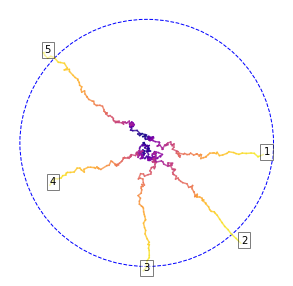

In [8]:
toy_model.to("cpu");
with torch.no_grad():
    sample = toy_model.prior_sample(shape=(1, 5, 2)).numpy().squeeze()

    
zT = [toy_model.prior_initial_sample(shape=(1, 5, 2))]
time_steps = torch.arange(toy_model._num_steps, dtype=torch.long).unsqueeze(-1)
with torch.no_grad():
    for t in reversed(time_steps):
        zT.append(
            toy_model.prior_onestep_sample(zT[-1], t=t)
        )    
zT = torch.stack(zT, dim=0).numpy().squeeze()

td.display_traj(zT)
td.discretize(zT[-1])+1